## Downloading the data from Kaggle

Follow these steps to download the data from Kaggle. Remove the comments and run it once then you don't need to run the codes again. 

In [1]:
# #Configuration environment in order to download the data from Kaggle
# import os

# os.environ['KAGGLE_USERNAME'] = "" # username from the json file
# os.environ['KAGGLE_KEY'] = "" # key from the json file

In [2]:
# !kaggle competitions download -c kitchenware-classification

In [3]:
# !mkdir data
# !unzip kitchenware-classification.zip -d data > /dev/null
# !rm kitchenware-classification.zip

Now the command below confirms that the downloaded files were structured into relevant directories. 

In [4]:
!ls

data				  README.md
kitchenware-classification.ipynb  single-gpu-tensorflow.ipynb
notebook-kitchenware.ipynb


## Importing relevant libraries

You now import the relevant libraries. Then the dataframe for organizing the files are created in order to be able to separate them into train, validation, and test sets. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

2022-12-30 06:31:48.510040: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
df_train_full = pd.read_csv('data/train.csv', dtype={'Id': str})
df_train_full['filename'] = 'data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [4]:
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

Now that the separation into train and validation datasets is done, we can now invoke our Xception model to use for transfer learning. 

Let's load an image of glass to see how it looks like. We'll get the image path from the dataframe above. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
from tensorflow.keras.preprocessing.image import load_img

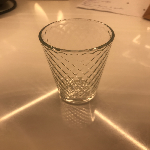

In [8]:
# image of a glass
full_name = df_train_full.loc[0, 'filename']
load_img(full_name, target_size=(150,150))

## Transfer Learning

Transfer learning, which is the use of a previously learned problem on a new problem, will be using the Xception model. The Xception model is a previously trained model on more than 1000 images. 

In [9]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

I will now process the images and create the classes, specifying the batch size as 32. I am using a smaller file size, 150x150, so that the training can be easily done. 

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


Let me show you how the classes are structured in the network. 

In [11]:
train_ds.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

So, you can see that for the kitchen ware task, we have cups, forks, glasses, knives, plates and spoons. 

## Base Model

I will now create a base model. In the base model, we will use the convolutional layers of Xception without the Dense layers. Every other aspect of the dense layers will be carried out during the experimentation where I will aim to find the best model. 

In [11]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

2022-12-27 05:16:46.586369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 05:16:46.592991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 05:16:46.593628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 05:16:46.594505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Compiling the base model

In [12]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Fitting the data sets to the compiled model. 

In [13]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10


2022-12-27 05:17:04.760993: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-27 05:17:05.422538: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-27 05:17:05.423474: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-27 05:17:05.423516: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-27 05:17:05.424485: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-27 05:17:05.424575: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


139/139 [==============================] - 75s 505ms/step - loss: 0.6851 - accuracy: 0.8309 - val_loss: 0.6059 - val_accuracy: 0.8669
Epoch 2/10
139/139 [==============================] - 62s 448ms/step - loss: 0.4314 - accuracy: 0.8914 - val_loss: 0.5753 - val_accuracy: 0.8858
Epoch 3/10
139/139 [==============================] - 62s 445ms/step - loss: 0.2560 - accuracy: 0.9276 - val_loss: 0.5977 - val_accuracy: 0.8876
Epoch 4/10
139/139 [==============================] - 62s 446ms/step - loss: 0.2012 - accuracy: 0.9447 - val_loss: 0.7274 - val_accuracy: 0.8705
Epoch 5/10
139/139 [==============================] - 62s 450ms/step - loss: 0.1449 - accuracy: 0.9530 - val_loss: 0.6587 - val_accuracy: 0.8750
Epoch 6/10
139/139 [==============================] - 62s 445ms/step - loss: 0.0773 - accuracy: 0.9735 - val_loss: 0.7378 - val_accuracy: 0.8750
Epoch 7/10
139/139 [==============================] - 62s 445ms/step - loss: 0.0685 - accuracy: 0.9764 - val_loss: 0.7842 - val_accuracy: 0.8

Let's see a chart of how the model learned the features of the train dataset and what happened thereafter. 

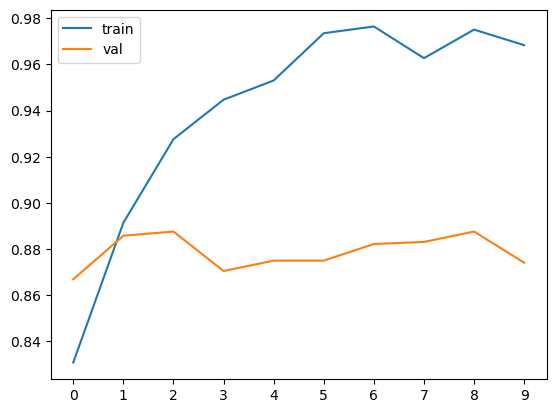

In [14]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

It is evident that the model was overfitting on the train and validation data set. It could generalize well on the train data seet but poorly on the validation data set. That problem will be fixed next. 

### Adjusting the learning rate

The learning rate determines how fast or slow we move towards the optimal weights when trying to adjust the weights of the network using gradient descent. I will use high and low values for the learning rate to find out which gives the optimal validation accuracy. 

In [22]:
def make_model(learning_rate=0.01):
    """
    This function is used to create the model without the dense layers.
    It returns the model
    """
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [23]:
# I now try different values of learning rates in a loop
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
139/139 [==============================] - 64s 449ms/step - loss: 1.2371 - accuracy: 0.5584 - val_loss: 0.7972 - val_accuracy: 0.7608
Epoch 2/10
139/139 [==============================] - 62s 444ms/step - loss: 0.6529 - accuracy: 0.8107 - val_loss: 0.5550 - val_accuracy: 0.8345
Epoch 3/10
139/139 [==============================] - 61s 442ms/step - loss: 0.5008 - accuracy: 0.8466 - val_loss: 0.4686 - val_accuracy: 0.8516
Epoch 4/10
139/139 [==============================] - 62s 445ms/step - loss: 0.4331 - accuracy: 0.8637 - val_loss: 0.4221 - val_accuracy: 0.8633
Epoch 5/10
139/139 [==============================] - 62s 443ms/step - loss: 0.3919 - accuracy: 0.8759 - val_loss: 0.3938 - val_accuracy: 0.8651
Epoch 6/10
139/139 [==============================] - 61s 443ms/step - loss: 0.3633 - accuracy: 0.8808 - val_loss: 0.3749 - val_accuracy: 0.8705
Epoch 7/10
139/139 [==============================] - 62s 445ms/step - loss: 0.3412 - accuracy: 0.8873 - val_loss: 0.3626 -

Visualizing the results for a detailed view. 

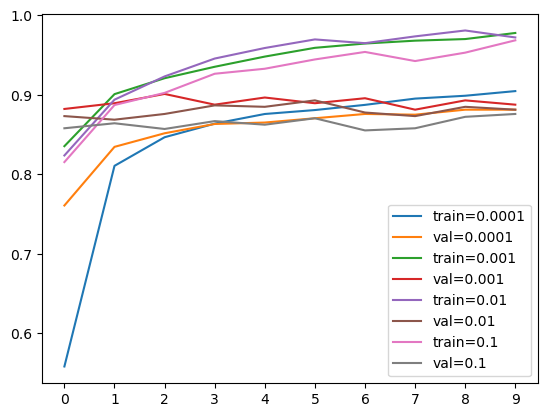

In [24]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [25]:
# removing the scores for the lowest validations
del scores[0.1]
del scores[0.0001]

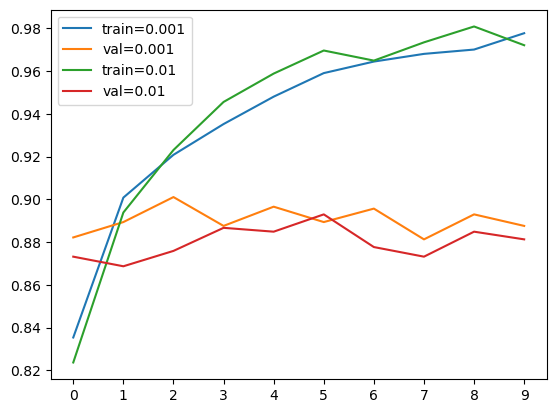

In [26]:
# visualizing it again
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

There is still overfitting, but we have something better than what we got for the base model. 
The best learning rate is 0.001.

In [15]:
learning_rate = 0.001

#### Checkpointing the best learning rate

Let's save the best model for the given learning rate above

In [12]:
model.save_weights('model_v1.h5', save_format='h5')

NameError: name 'model' is not defined

In [30]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [31]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/10
139/139 [==============================] - 65s 451ms/step - loss: 0.4995 - accuracy: 0.8262 - val_loss: 0.3309 - val_accuracy: 0.8903
Epoch 2/10
139/139 [==============================] - 61s 441ms/step - loss: 0.2808 - accuracy: 0.8995 - val_loss: 0.3141 - val_accuracy: 0.8894
Epoch 3/10
139/139 [==============================] - 62s 444ms/step - loss: 0.2302 - accuracy: 0.9208 - val_loss: 0.2963 - val_accuracy: 0.8948
Epoch 4/10
139/139 [==============================] - 62s 443ms/step - loss: 0.1924 - accuracy: 0.9323 - val_loss: 0.2962 - val_accuracy: 0.9002
Epoch 5/10
139/139 [==============================] - 61s 439ms/step - loss: 0.1657 - accuracy: 0.9449 - val_loss: 0.3077 - val_accuracy: 0.8894
Epoch 6/10
139/139 [==============================] - 61s 442ms/step - loss: 0.1406 - accuracy: 0.9577 - val_loss: 0.3032 - val_accuracy: 0.8984
Epoch 7/10
139/139 [==============================] - 61s 443ms/step - loss: 0.1280 - accuracy: 0.9631 - val_loss: 0.2983 - val_ac

## Adding Layers

We have been training the model without adding dense layers. Now I will make the model a little more complex by adding one or two layers. First, I will test it with one layer, check out if the model improved and whether I will need to add a second layer. 

In [16]:
def make_model(learning_rate=0.01, size_inner=100): # size_inner is the number of neurons in the first layer
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

I will try various number of neurons for the first inner layer and check out the result. I will also increase the epochs a little. 

In [17]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 500, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/20
139/139 [==============================] - 65s 450ms/step - loss: 0.7880 - accuracy: 0.7176 - val_loss: 0.5093 - val_accuracy: 0.8273
Epoch 2/20
139/139 [==============================] - 62s 450ms/step - loss: 0.3608 - accuracy: 0.8835 - val_loss: 0.3353 - val_accuracy: 0.8885
Epoch 3/20
139/139 [==============================] - 63s 451ms/step - loss: 0.2549 - accuracy: 0.9114 - val_loss: 0.3053 - val_accuracy: 0.8903
Epoch 4/20
139/139 [==============================] - 62s 449ms/step - loss: 0.2079 - accuracy: 0.9303 - val_loss: 0.2927 - val_accuracy: 0.8993
Epoch 5/20
139/139 [==============================] - 62s 448ms/step - loss: 0.1778 - accuracy: 0.9418 - val_loss: 0.3005 - val_accuracy: 0.8948
Epoch 6/20
139/139 [==============================] - 61s 442ms/step - loss: 0.1547 - accuracy: 0.9505 - val_loss: 0.3061 - val_accuracy: 0.8948
Epoch 7/20
139/139 [==============================] - 61s 442ms/step - loss: 0.1311 - accuracy: 0.9600 - val_loss: 0.2976 - val

Visualizing the results above. 

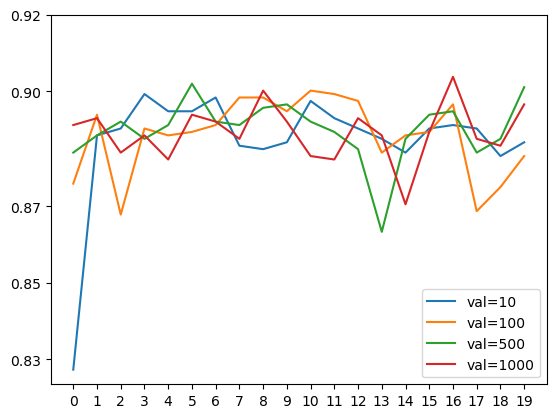

In [21]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(20))
plt.yticks([0.83, 0.85, 0.87, 0.90, 0.92])
plt.legend()

Having 500 neurons in the first layer is somewhat adequate. I will make the model more complext by inserting a second layer to see what the result will be. Then I will determine if to go with just one layer or two layers. 

In [22]:
def make_model(learning_rate=0.01, size_inner1=100, size_inner2=500): # size_inner is the number of neurons in the first layer
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner1 = keras.layers.Dense(size_inner1, activation='relu')(vectors)
    inner2 = keras.layers.Dense(size_inner2, activation='relu')(inner1)
    
    outputs = keras.layers.Dense(6)(inner2)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [23]:
learning_rate = 0.001
size_inner1 = 500
scores = {}

for size in [10, 100, 500, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner1=size_inner1, size_inner2=size)
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/20
139/139 [==============================] - 65s 449ms/step - loss: 0.5952 - accuracy: 0.7697 - val_loss: 0.3843 - val_accuracy: 0.8624
Epoch 2/20
139/139 [==============================] - 61s 442ms/step - loss: 0.2839 - accuracy: 0.8961 - val_loss: 0.3340 - val_accuracy: 0.8840
Epoch 3/20
139/139 [==============================] - 62s 443ms/step - loss: 0.1929 - accuracy: 0.9307 - val_loss: 0.3224 - val_accuracy: 0.8903
Epoch 4/20
139/139 [==============================] - 62s 444ms/step - loss: 0.1449 - accuracy: 0.9449 - val_loss: 0.3516 - val_accuracy: 0.8939
Epoch 5/20
139/139 [==============================] - 62s 447ms/step - loss: 0.1092 - accuracy: 0.9579 - val_loss: 0.3405 - val_accuracy: 0.9029
Epoch 6/20
139/139 [==============================] - 61s 442ms/step - loss: 0.0930 - accuracy: 0.9642 - val_loss: 0.3646 - val_accuracy: 0.8975
Epoch 7/20
139/139 [==============================] - 61s 442ms/step - loss: 0.0716 - accuracy: 0.9735 - val_loss: 0.3554 - val

Visualizing the results of adding a second layer. 

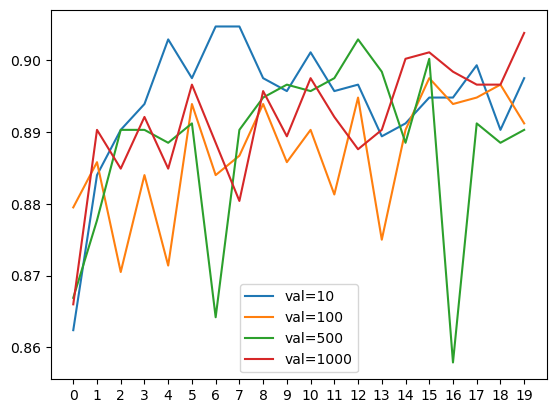

In [24]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(20))
#plt.yticks([0.83, 0.85, 0.87, 0.90, 0.92])
plt.legend()

Adding a second layer doesn't give a significant return from having only 1 hidden layer. So, I will use the results of just 1 hidden layer. 

Now, I will try out regularization to see what impact it will make. 

## Regularization and Dropout

You should have noticed that our model has been overfitting. Regularization will serve to reduce overfitting. The regularization technique I will use is having a drop out. 

With dropout, using probability techniques, a section of the neurons is turned off during training. These helps the model in reducing overfitting and filtering out the neurons that are overfitting. 

In [28]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5): # size_inner is the number of neurons in the first layer
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [29]:
learning_rate = 0.001
size = 500

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
139/139 [==============================] - 64s 447ms/step - loss: 0.4421 - accuracy: 0.8446 - val_loss: 0.3801 - val_accuracy: 0.8597
Epoch 2/30
139/139 [==============================] - 61s 441ms/step - loss: 0.2123 - accuracy: 0.9233 - val_loss: 0.3513 - val_accuracy: 0.8867
Epoch 3/30
139/139 [==============================] - 62s 445ms/step - loss: 0.1399 - accuracy: 0.9460 - val_loss: 0.3271 - val_accuracy: 0.8885
Epoch 4/30
139/139 [==============================] - 62s 444ms/step - loss: 0.1148 - accuracy: 0.9575 - val_loss: 0.5315 - val_accuracy: 0.8597
Epoch 5/30
139/139 [==============================] - 62s 447ms/step - loss: 0.0697 - accuracy: 0.9764 - val_loss: 0.4286 - val_accuracy: 0.8813
Epoch 6/30
139/139 [==============================] - 61s 441ms/step - loss: 0.0401 - accuracy: 0.9883 - val_loss: 0.3787 - val_accuracy: 0.8957
Epoch 7/30
139/139 [==============================] - 61s 442ms/step - loss: 0.0253 - accuracy: 0.9942 - val_loss: 0.4468 - va

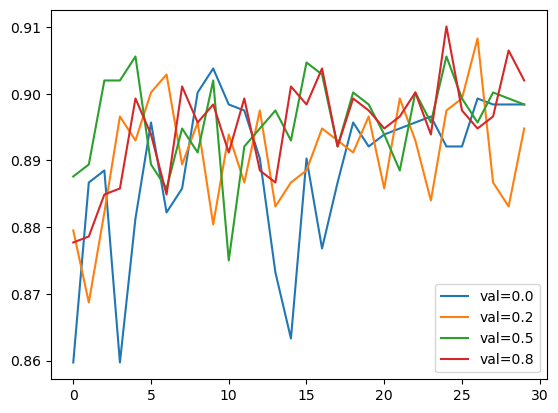

In [30]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

#plt.ylim(0.78, 0.86)
plt.legend()

Dropout rate of 0.8 looks better than the others. Visualizing the overfit.

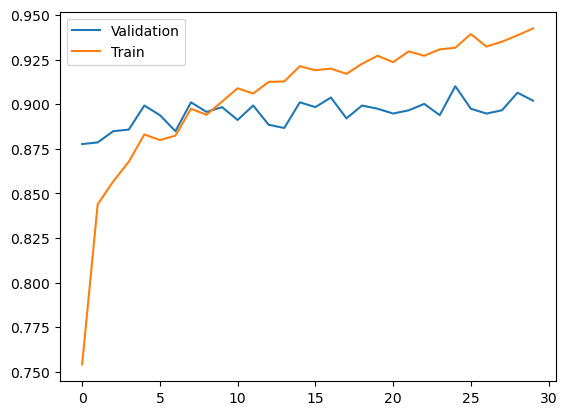

In [31]:
hist = scores[0.8]
plt.plot(hist['val_accuracy'], label="Validation")

plt.plot(hist['accuracy'], label="Train")

plt.legend()

We can see that with a dropout rate of 0.8, the overfitting is much reduced. 

We could improve the model further by some data augmentation. 

## Data Augmentation

In data augmentation, we artificially increase the amount of data by generating synthetic data from existing data. This might involve rotating the data, shearing it, flipping it, or even shifting it horizontally or vertically. I will try out different data augmentation techniques and chose the ones that give better results. 

In [17]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, width_shift_range=5, height_shift_range=10, 
                                  shear_range=10, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)

train_ds = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [18]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5): # size_inner is the number of neurons in the first layer
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [19]:
learning_rate = 0.001
size = 500
droprate = 0.8

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
139/139 [==============================] - 82s 575ms/step - loss: 0.8350 - accuracy: 0.7142 - val_loss: 0.3513 - val_accuracy: 0.8786
Epoch 2/50
139/139 [==============================] - 79s 568ms/step - loss: 0.5494 - accuracy: 0.8021 - val_loss: 0.3284 - val_accuracy: 0.8750
Epoch 3/50
139/139 [==============================] - 79s 566ms/step - loss: 0.5336 - accuracy: 0.8084 - val_loss: 0.3178 - val_accuracy: 0.8786
Epoch 4/50
139/139 [==============================] - 79s 570ms/step - loss: 0.4895 - accuracy: 0.8271 - val_loss: 0.3210 - val_accuracy: 0.8777
Epoch 5/50
139/139 [==============================] - 79s 568ms/step - loss: 0.4698 - accuracy: 0.8345 - val_loss: 0.3120 - val_accuracy: 0.8867
Epoch 6/50
139/139 [==============================] - 79s 568ms/step - loss: 0.4714 - accuracy: 0.8320 - val_loss: 0.3090 - val_accuracy: 0.8876
Epoch 7/50
139/139 [==============================] - 79s 569ms/step - loss: 0.4607 - accuracy: 0.8343 - val_loss: 0.3081 - val_ac

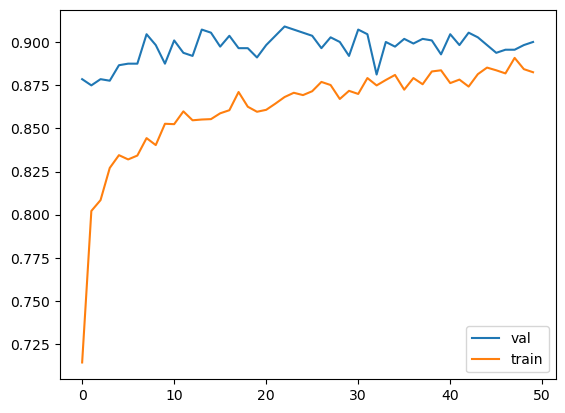

In [20]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

Observations:
    
    1. Augmentation by shifting the width and height did not increase validation accuracy but reduced overfitting. So I am keeping it. 
    2, Augmentation by shearing decreased the distance between training and validation accuracy but the overall accuracy didn't increase much. 
    3. Zooming further reduced the overfitting. But the goal is to increase validation accuracy. Let me try horizontal and vertical flipping. 
    4. Flipping made the validation accuracy higher than the train accuracy. I guess now that by flipping, the model is struggling with the train and getting better results than the validation. 
    After augmentation though, the improvements were minimal. I think that with a higher image, I could get a higher accurate result. 
    
    

## Training with higher image resolution

I have been using images of size 150x150 because I want to experiment with building the model. To get a better model, although it will train slower, I need to upgrade the image size. I will use 299x299 image sizes for the new training phase. 

In [13]:
def make_model(input_size= 150, learning_rate=0.01, size_inner=100, droprate=0.5): # size_inner is the number of neurons in the first layer
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [14]:
input_size = 299

In [15]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, width_shift_range=5, height_shift_range=10, 
                                  shear_range=10, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)

train_ds = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(input_size, input_size),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(input_size, input_size),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [16]:
#model.save_weights('model_vlarge.h5', save_format='h5')

NameError: name 'model' is not defined

In [19]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_vlarge_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [20]:
learning_rate = 0.001
size = 500
droprate = 0.8

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/50


2022-12-30 06:48:25.396335: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-30 06:48:26.059862: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-30 06:48:26.060795: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-30 06:48:26.060835: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-30 06:48:26.061881: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-30 06:48:26.061981: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


139/139 [==============================] - 154s 1s/step - loss: 0.4594 - accuracy: 0.8451 - val_loss: 0.1333 - val_accuracy: 0.9550
Epoch 2/50
139/139 [==============================] - 139s 997ms/step - loss: 0.2908 - accuracy: 0.9026 - val_loss: 0.1303 - val_accuracy: 0.9613
Epoch 3/50
139/139 [==============================] - 139s 1s/step - loss: 0.2566 - accuracy: 0.9132 - val_loss: 0.1259 - val_accuracy: 0.9604
Epoch 4/50
139/139 [==============================] - 140s 1s/step - loss: 0.2208 - accuracy: 0.9260 - val_loss: 0.1221 - val_accuracy: 0.9604
Epoch 5/50
139/139 [==============================] - 139s 1s/step - loss: 0.2282 - accuracy: 0.9168 - val_loss: 0.1276 - val_accuracy: 0.9622
Epoch 6/50
139/139 [==============================] - 140s 1s/step - loss: 0.2147 - accuracy: 0.9251 - val_loss: 0.1218 - val_accuracy: 0.9577
Epoch 7/50
139/139 [==============================] - 138s 995ms/step - loss: 0.2180 - accuracy: 0.9269 - val_loss: 0.1288 - val_accuracy: 0.9613
Epoc

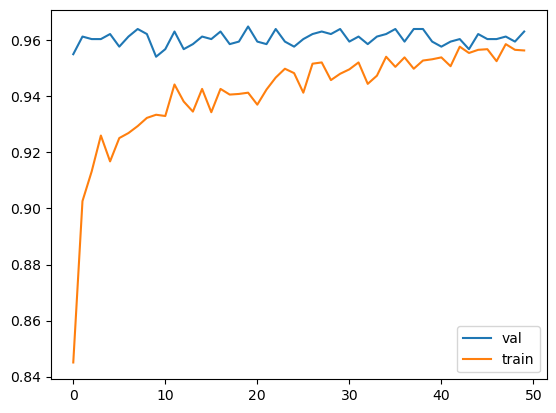

In [21]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

I like the results from the above assessment. 0.96 for validation is a good result. But maybe I can do better. It is evident that the model may be resonating around a local minimum. Let me change the learning rate to see if I can get a better result than an oscillation around a constant. Otherwise, I go for the above results. 

In [22]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_vlarge2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [23]:
learning_rate = 0.0005
size = 500
droprate = 0.8

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/50
139/139 [==============================] - 140s 989ms/step - loss: 0.5138 - accuracy: 0.8282 - val_loss: 0.1567 - val_accuracy: 0.9478
Epoch 2/50
139/139 [==============================] - 134s 964ms/step - loss: 0.2777 - accuracy: 0.9058 - val_loss: 0.1321 - val_accuracy: 0.9523
Epoch 3/50
139/139 [==============================] - 135s 968ms/step - loss: 0.2404 - accuracy: 0.9170 - val_loss: 0.1185 - val_accuracy: 0.9613
Epoch 4/50
139/139 [==============================] - 134s 966ms/step - loss: 0.2297 - accuracy: 0.9226 - val_loss: 0.1179 - val_accuracy: 0.9604
Epoch 5/50
139/139 [==============================] - 135s 967ms/step - loss: 0.1938 - accuracy: 0.9339 - val_loss: 0.1278 - val_accuracy: 0.9532
Epoch 6/50
139/139 [==============================] - 137s 985ms/step - loss: 0.1936 - accuracy: 0.9325 - val_loss: 0.1181 - val_accuracy: 0.9631
Epoch 7/50
139/139 [==============================] - 134s 963ms/step - loss: 0.1823 - accuracy: 0.9391 - val_loss: 0.1136 -

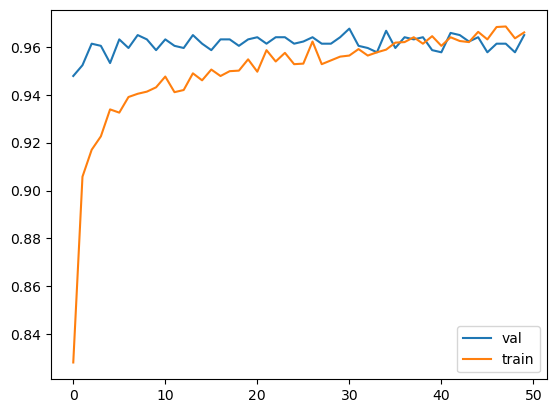

In [24]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

Reducing the learning rate to 0.0005 gave a better fit this time. You can see that the accuracy on validation data mimics that of train data with very low difference. Therefore, there is little chance of overfitting in this model. I will use this model henceforth. Also, the percentage accuracy is better than the other models. 

Now, it's time to use the model on test data. 

## Using The Model On Test Data

In [25]:
df_test = pd.read_csv('data/test.csv', dtype={'Id': str})
df_test['filename'] = 'data/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,data/images/0678.jpg
1,3962,data/images/3962.jpg
2,9271,data/images/9271.jpg
3,5133,data/images/5133.jpg
4,8842,data/images/8842.jpg


In [36]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


test_ds = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 3808 validated image filenames.


First import the best model

In [37]:
model = keras.models.load_model('xception_vlarge2_31_0.968.h5')

Now I will evaluate the model to see its accuracy on unseen test data.

In [39]:
y_pred = model.predict(test_ds)

119/119 [==============================] - 57s 472ms/step


Getting the classes of the different images

In [40]:
classes = np.array(list(train_ds.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

Generating the classes for the prediction

In [41]:
predictions = classes[y_pred.argmax(axis=1)]

Will now create a file for submission to Kaggle

In [42]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_ds.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]

del df_submission['filename']

In [43]:
df_submission[['Id', 'label']].to_csv('submissionlarge.csv', index=False)

To see what metrics I will get on evaluating the test data live. 

In [44]:
model.evaluate(test_ds)

ValueError: in user code:

    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/engine/training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/engine/training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/engine/training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/engine/training.py", line 1501, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None, None, None) and (None, 6) are incompatible
